In [1]:
import os
from shutil import rmtree

import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import sys
sys.path.insert(0, '../input/utilspy')
import utils

import random
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

from tqdm.auto import tqdm

from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn import metrics

In [2]:
shavers = utils.Shavers('../input/shaver-shell-full-all-classes-v2/shaver-shell-full/',
                        normalize_transform=utils.normalize)

In [3]:
def train_model(embeddings):
    model = MLPClassifier(random_state=744, max_iter=10000)

    Xr = embeddings(shavers)
    yr = np.array(shavers.targets)

    X_train, X_test, y_train, y_test = train_test_split(Xr, yr, test_size=0.3, random_state=744)
    
    model.fit(X_train, y_train)
    
    return model

In [4]:
def model_predict(Xt, model, embeddings):
    X = embeddings(Xt, tqdm_suppress = True)
    preds = model.predict(X)
    return preds

In [5]:
model_resnet = train_model(utils.get_resnet50_embeddings)
model_vgg = train_model(utils.get_vgg16_embeddings)
model_inception = train_model(utils.get_inception_embeddings)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/3518 [00:00<?, ?it/s]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0/3518 [00:00<?, ?it/s]

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

  0%|          | 0/3518 [00:00<?, ?it/s]

In [6]:
ls '/kaggle/input/sefaoutput/sefa_pcl_shaver_aug_images' | wc -l 

109890


In [7]:
!mkdir -p './tmp/19-01 synth'
!ln -s '/kaggle/input/sefaoutput/sefa_pcl_shaver_aug_images' './tmp/19-01 synth'

In [8]:
generated_images = utils.Shavers('./tmp/19-01 synth',
                     normalize_transform=utils.normalize)

In [9]:
def calculate_disagreement(p1, p2, p3):
    if (p1!=p2) and (p2!=p3) and (p3!=p1):
        return 3
    elif (p1 == p2) and (p2 == p3):
        return 1
    else:
        return 2

  0%|          | 0/15 [00:00<?, ?it/s]

(array([5852.,    0.,    0.,    0.,    0., 6823.,    0.,    0.,    0.,
        2255.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

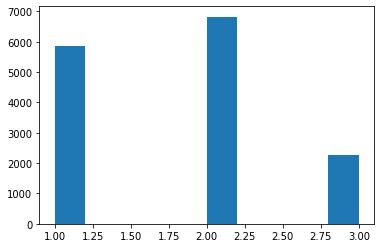

In [10]:
disagreement_scores = []
scored_paths = []

img_paths = [t[0] for t in generated_images.samples]
sampled_gen_images = np.random.choice(img_paths, 15000)

batchsize = 1000
for i in tqdm(range(0, len(sampled_gen_images), batchsize)):
    image_paths = sampled_gen_images[i:i+batchsize]
    os.makedirs("./tmp2/19-01 synth", exist_ok = True)
    for image_path in image_paths:
        shutil.copy(image_path, "./tmp2/19-01 synth/")
    
    batch_image_ds = utils.Shavers('./tmp2/',
                     normalize_transform=utils.normalize)
    resnet_preds = model_predict(batch_image_ds, model_resnet, utils.get_resnet50_embeddings)
    vgg_preds = model_predict(batch_image_ds, model_vgg, utils.get_vgg16_embeddings)
    inception_preds = model_predict(batch_image_ds, model_inception, utils.get_inception_embeddings)
    
    for j in range(len(resnet_preds)):
        score = calculate_disagreement(resnet_preds[j], vgg_preds[j], inception_preds[j])
        disagreement_scores.append(score)
        scored_paths.append(image_paths[j])
        
    shutil.rmtree("./tmp2")
        
plt.hist(disagreement_scores)

In [11]:
!mkdir -p 'sefa_augmented/19-01 synth'

In [12]:
len(disagreement_scores)


14930

In [13]:
i = 0
collected = 0

for image_path in scored_paths:
    if(disagreement_scores[i] == 3 and collected < 0.7*len(shavers.samples)):
        shutil.copy(image_path, "./sefa_augmented/19-01 synth/")
        collected += 1
    i+=1
    
remaining = int(round(0.7*len(shavers.samples) - collected))

j = 0
for image_path in scored_paths:
    if remaining == 0:
        break
    if(disagreement_scores[j] == 2):
        shutil.copy(image_path, "./sefa_augmented/19-01 synth/")
        remaining -= 1
    j+=1

In [14]:
!mkdir -p 'sefa_augmented/19-01 dubbeldruk'
!mkdir -p 'sefa_augmented/19-01 goed'
!mkdir -p 'sefa_augmented/19-01 onderbroken'
!cp "/kaggle/input/shaver-shell-full-all-classes-v2/shaver-shell-full/19-01 dubbeldruk/"* "./sefa_augmented/19-01 dubbeldruk/"
!cp "/kaggle/input/shaver-shell-full-all-classes-v2/shaver-shell-full/19-01 goed/"* "./sefa_augmented/19-01 goed/"
!cp "/kaggle/input/shaver-shell-full-all-classes-v2/shaver-shell-full/19-01 onderbroken/"* "./sefa_augmented/19-01 onderbroken/"

In [15]:
!ls "./sefa_augmented/19-01 dubbeldruk/" | wc -l
!ls "./sefa_augmented/19-01 goed/" | wc -l
!ls "./sefa_augmented/19-01 onderbroken/" | wc -l
!ls "./sefa_augmented/19-01 synth/" | wc -l

244
2677
598
2432


In [16]:
!rm -r ./tmp